In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

In [ ]:
# !pip install mlflow

In [84]:
!databricks configure --host https://community.cloud.databricks.com/
import mlflow
mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/desmondstha125@gmail.com/toxic_comment_classification")

Username: desmondstha125@gmail.com
Password: 
Repeat for confirmation: 


Loading data from drive

In [86]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")
testText = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv')
testLevel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test_labels.csv/test_labels.csv")

In [ ]:
print("Shape of train data: ", train.shape)
print("Shape of test data: ", testText.shape)

Shape of train data:  (159571, 8)
Shape of test data:  (153164, 2)


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
testText.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
testLevel.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [87]:
test = pd.merge(testText,testLevel, on='id')
test = test[test['toxic']!=-1]
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [ ]:
test.shape

(63978, 8)

In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [ ]:
train[train.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

Visualzing the data

<ipython-input-5-b8bd4b0944ea>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comment_len,kde=False, color="blue")


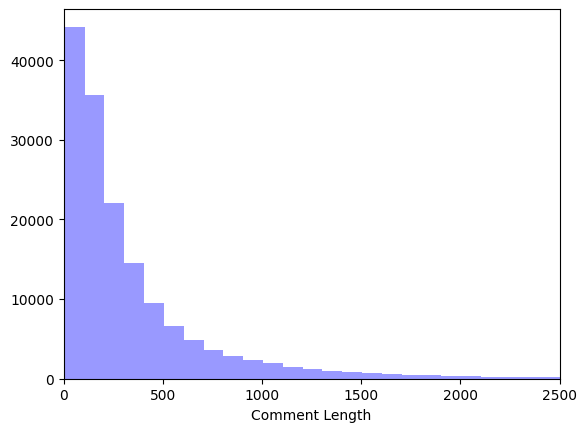

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len,kde=False, color="blue")
plt.xlim(0, 2500)

plt.xlabel('Comment Length')

# Display the plot
plt.show()

We can see most of the comments have short length and very few have length grater than 1000

Plotting the correlational matrix

<Axes: >

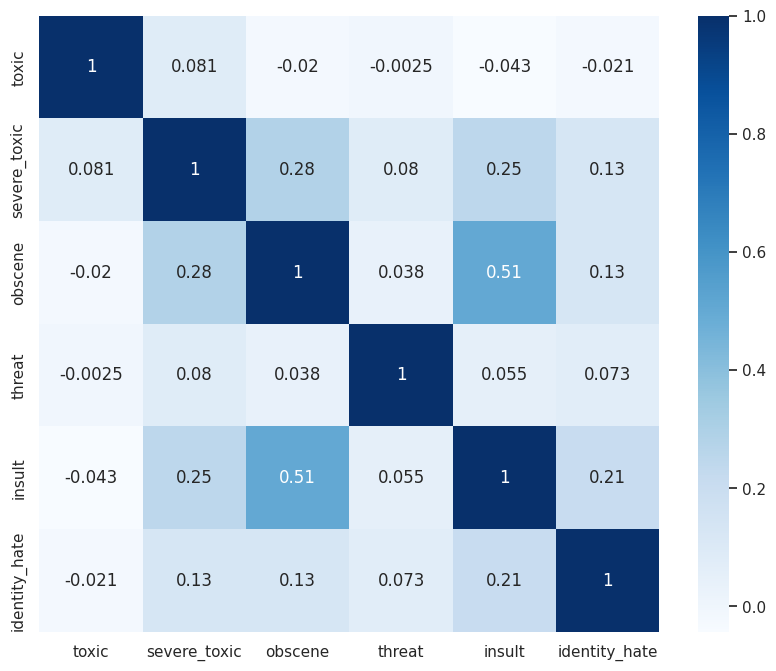

In [ ]:
rowsums = train.iloc[:, 2:8].sum(axis=1)
temp = train.iloc[:, 2:8]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

The highest levels of correlation can
be observed between the obscene and toxic

Preprocessing the data



1.   Removing Characters in between Text.
2. Removing Repeated Characters.

1.   Converting data to lower-case.
2.   Removing Punctuation.
3.   Removing unnecessary white spaces in between words.
2.   Removing “\n”.
3. Removing Non-English characters.





In [88]:
import re

def clean_text(text,remove_repeat_text=True, is_lower=True):

  if is_lower:
    text=text.lower()

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)  #removes repeated characters.
    # uses regular expressions (re) to find consecutive occurrences of a character
    # and replaces them with a single instance of that character.
    # For example, it replaces "loooove" with "love" by reducing consecutive repeated characters to a single occurrence

  text = str(text).replace("\n", " ") #replaces newline characters (\n) with a space character
  text = re.sub(r'[^\w\s]',' ',text) #substitute any non-alphanumeric and non-whitespace characters with a space character.
  text = re.sub('[0-9]',"",text) #remove any numeric digits from the text
  text = re.sub(" +", " ", text) #replace multiple consecutive spaces with a single space
  text = re.sub("([^\x00-\x7F])+"," ",text) #remove any non-ASCII characters from the text
  return text

In [89]:
train['comment_text'] = train['comment_text'].apply(clean_text)
test['comment_text'] = test['comment_text'].apply(clean_text)

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,thank you for understanding i think very highl...,0,0,0,0,0,0
7,000247e83dcc1211,dear god this site is horrible,0,0,0,0,0,0
11,0002f87b16116a7f,somebody will invariably try to add religion ...,0,0,0,0,0,0
13,0003e1cccfd5a40a,it says it right there that it is a type the ...,0,0,0,0,0,0
14,00059ace3e3e9a53,before adding a new product to the list make ...,0,0,0,0,0,0


Removing Stopwords using NLTK stopwords

In [90]:
import nltk
from nltk.corpus import stopwords

In [91]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
testText.shape

(153164, 2)

In [9]:
from tqdm.notebook import tqdm_notebook

In [92]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stop_words:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

#Removing Stopwords from Training Data
processed_train_data = []
for line in train["comment_text"]:
    processed_train_data.append(remove_stopwords(line))

#Removing Stopwords from Test Data
processed_test_data = []
for line in test["comment_text"]:
    processed_test_data.append(remove_stopwords(line))

In [ ]:
processed_train_data[0]

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

In [ ]:
processed_test_data[0]

'thank understanding think highly would revert without discussion'

In [93]:
train["comment_text"] = processed_train_data
test["comment_text"] = processed_test_data
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


Tokenization

In [94]:
CATEGORIES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train = train["comment_text"]
y_train = train[CATEGORIES].values
X_test = test['comment_text']
y_test = test[CATEGORIES].values
X_train

0         explanation edits made username hardcore metal...
1         aww matches background colour seemingly stuck ...
2         hey man really trying edit war guy constantly ...
3         make real suggestions improvement wondered sec...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm theres actual article prostitution...
159569    looks like actually put speedy first version d...
159570    really think understand came idea bad right aw...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
y_train[6]

array([1, 1, 1, 0, 1, 0])

Tokenization and Padding the sequence

In [95]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

max_features=100000
maxpadlen = 500

tokenizer = Tokenizer(num_words=max_features,oov_token='<nothing>')
tokenizer.fit_on_texts(X_train)

def tokenization(data):
  data = tokenizer.texts_to_sequences(data)
  data=pad_sequences(data, maxlen=maxpadlen, padding = 'post')
  return data

X_train = tokenization(X_train)
X_test = tokenization(X_test)

Initaialing the word embedding using Sentence Transformer

Importing sentence transformer

In [ ]:
# !pip install sentence-transformers

In [ ]:
# from sentence_transformers import SentenceTransformer

# model_name = 'all-MiniLM-L6-v2'
# sentence_transformer_model = SentenceTransformer(model_name)

In [ ]:
# Converting sequences back to sentences
# sentences = tokenizer.sequences_to_texts(X_train)

# Obtaining sentence embeddings using the Sentence Transformer model
# sentence_embeddings = sentence_transformer_model.encode(sentences)

Saving the sentence_embedding in drive

In [ ]:
# df_embeddings = pd.DataFrame(sentence_embeddings)
# df_embeddings.to_csv('/content/drive/MyDrive/Colab Notebooks/sentence_embeddings.csv', index=False)

In [ ]:
# type(sentence_embeddings)

numpy.ndarray

Directly load the embedded sentences

In [119]:
loaded_df_embeddings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sentence_embeddings.csv')
sentence_embeddings = loaded_df_embeddings.values

Creating a LSTM model

In [100]:
import tensorflow
from keras.models import Model
from keras.layers import *
from keras.utils import plot_model

In [121]:
num_classes = 6
epochs = 1
batch_size = 128
threshold = 0.5

In [105]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluation(prediction, actual, col):
  accuracy = accuracy_score(actual[col], prediction[col])
  f1 = f1_score(actual[col], prediction[col], average='weighted')
  recall = recall_score(actual[col], prediction[col], average='weighted')
  precision = precision_score(actual[col], prediction[col], average='weighted')

  print("Accuracy of ",col , " is: " ,accuracy)
  print("F1-score of",col , " is: " ,f1)
  print("Recall of",col , " is: " ,recall)
  print("Precision of",col , " is: " ,precision)

  # Plot the confusion matrix
def plot_confusion(prediction, actual, col):
  cm = confusion_matrix(actual[col], prediction[col])
  classes = [col]

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

Function for defining LSTM model

In [122]:
def lstmModel():
  inp=Input(shape=(maxpadlen, ),dtype='int32')
  embedding_layer = Embedding(input_dim=sentence_embeddings.shape[0],  # Number of words in the vocabulary
                            output_dim=sentence_embeddings.shape[1],  # Size of the embeddings
                            weights=[sentence_embeddings],  # Use the loaded embeddings
                            input_length=maxpadlen,
                            trainable=False)  # Freeze the embeddings
  embedded_sequences = embedding_layer(inp)
  x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
  x = GlobalMaxPool1D()(x)
  x = Dropout(0.2)(x)
  x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
  x = Dropout(0.2)(x)
  preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

  #Compile the Model.
  lstm_model = Model(inputs=inp, outputs=preds)

  lstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
  return lstm_model



In [123]:
model = lstmModel()

In [106]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 384)          61275264  
                                                                 
 lstm_layer (LSTM)           (None, 500, 50)           87000     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 50)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_113 (Dropout)       (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 40)                2040      
                                                           

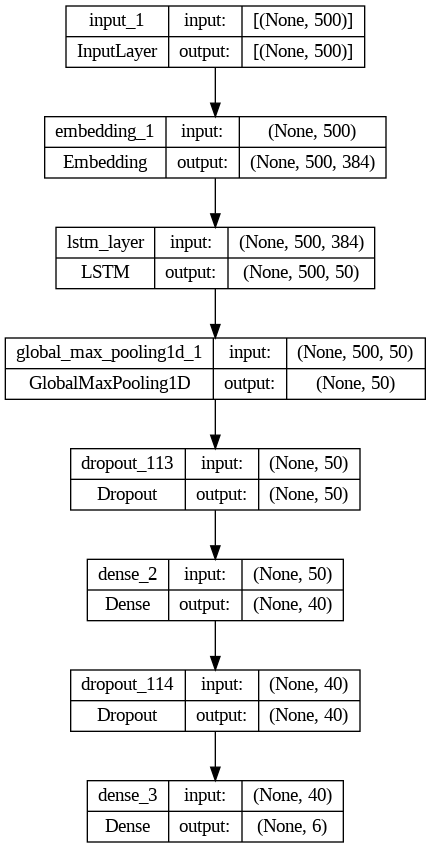

In [108]:
plot_model(model, show_shapes=True)

In [111]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix


def overal_eval(y_test, y_test_pred_labels):
  y_true_flat = y_test.ravel()
  y_pred_flat = y_test_pred_labels.ravel()
  accuracy = accuracy_score(y_true_flat, y_pred_flat)
  f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
  recall = recall_score(y_true_flat, y_pred_flat, average='weighted')
  precision = precision_score(y_true_flat, y_pred_flat, average='weighted')
  overall_auc = roc_auc_score(y_true_flat, y_pred_flat)

  fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f'Overall AUC = {overall_auc:.2f}')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC Curve')
  plt.legend()
  plt.savefig('auc_curve.png')

  return accuracy, f1, recall, precision, overall_auc

In [127]:
# Training the LSTM model

import mlflow.keras

mlflow.end_run()
def train_model(model, name):
  with mlflow.start_run():
    mlflow.keras.autolog()
    history = model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,  validation_split = 0.2)
    # model.save('/content/drive/MyDrive/Colab Notebooks/Toxic_comments_models/' + name)
    y_test_pred = model.predict(X_test)
    y_test_pred_labels = (y_test_pred > threshold).astype(int)

    accuracy, f1, recall, precision, overall_auc = overal_eval(y_test, y_test_pred_labels)

    mlflow.log_param("Model", name)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("F1_score", f1)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Overall AUC", overall_auc)
    mlflow.log_artifact('auc_curve.png')
    plt.close()

  return history

In [128]:
history = train_model(model, "LSTM model")

Train on 127656 samples, validate on 31915 samples
127656/127656 [==============================] - 529s 4ms/sample - loss: 0.0854 - accuracy: 0.9754 - val_loss: 0.0802 - val_accuracy: 0.9757


Making predictions

In [138]:
input_text = ["I fucking hate you"]
input_text = tokenization(input_text)
input_text
model.predict(input_text)

array([[0.9665368 , 0.23884182, 0.89593613, 0.0440357 , 0.7094443 ,
        0.14778888]], dtype=float32)